In [2]:
import sgkit as sg
import allel
import plotly.express as px
import seaborn as sns
import dendropy as dp
import matplotlib.pyplot as plt
import pandas as pd
from Bio import Phylo
import numpy as np
import os
import glob
from sklearn.mixture import GaussianMixture
from sklearn.utils.extmath import row_norms

In [3]:
#palettes
pop_code_cols = {
    'APA' : '#ff7f00', #orange
    'SAE' : '#6a3d9a', #dark purple
    'SAR' : '#cab2d6', #ligher purple
    'IRS' : '#c27a88', #not sure yet
    'IRH' : '#c57fc9', #not sure yet
    'INB' : '#96172e', #darkred
    'INM' : '#f03e5e', #lightred
    'DJI' : '#507d2a', #sap green
    'ETB' : '#007272', #cobalt turq
    'ETS' : '#33a02c',#green
    'ETW' : '#a6cee3',#cerulean
    'SUD' : '#fccf86',#ochre
    'YEM' : '#CC7722'#pinkish
}

Treemix takes a tab delimited file of allele counts by population - let's define our populations here based on the countries and the pca

In [4]:
ds_chr2 = sg.load_dataset('/Users/dennistpw/Projects/AsGARD/data/variants_combined_cohorts/combined_cohorts.CM023248.zarr')

#load and filter metadata
#load and filter metadata
df_samples = pd.read_csv('/Users/dennistpw/Projects/AsGARD/metadata/cease_combinedmetadata_noqc.20250212.csv')

#extract gts
gt = allel.GenotypeArray(ds_chr2.call_genotype)


#next, ld prune. this takes a wee while

In [5]:
#define stevegen1000 functions
def select_random_genos(
                    ds, 
                    numgenos,):
                     #selects given number of genos at random
                    keep_no = int(numgenos)
                    keep_indices = np.random.choice(ds.call_genotype.shape[0], keep_no, replace=False)
                    keep_indices.sort()
                    thinned_callset = ds.isel(variants=~keep_indices)
                    return(thinned_callset)
                    

def load_geno_ds(chrom, 
                sample_query=None, 
                numgenos=None, 
                sample_list=None, 
                start=None, 
                end=None, 
                min_minor_ac=0,
                df_samples=df_samples):
                 # load sample metadata
     #load ds
     ds = sg.load_dataset(f'/Users/dennistpw/Projects/AsGARD/data/variants_combined_cohorts/combined_cohorts.{chrom}.zarr')

     #if sample query or list are specified, subset accordingly
     if sample_query:
          # locate selected samples
          loc_samples = df_samples.eval(sample_query).values
          df_samples = df_samples.loc[loc_samples, :]
          ds = ds.isel(samples=loc_samples)
     elif sample_list:
          loc_samples = df_samples['sample_id'].isin(sample_list)
          df_samples = df_samples.loc[loc_samples, :]
          ds = ds.isel(samples=loc_samples)
     else:
          pass
          
     #if numgenos is set, subset 
     if numgenos:
          ds_analysis = select_random_genos(ds, numgenos=numgenos)
     else:
          ds_analysis = ds

     #if region is set, subset to region
     if start:
               #subset to region of interest
              print(f"subsetting genos to range {chrom}:{start}-{end}")
              ds_analysis = ds_analysis.set_index(variants=("variant_contig", "variant_position")).sel(variants=(0, slice(start,end)))
     else:
            pass
     
     #if minmaf is specified, select minmaf     
     ac = allel.GenotypeArray(ds_analysis['call_genotype']).count_alleles()
     macbool = ac[:,1] >= min_minor_ac
     print(f'selected {np.sum(macbool)} sites with a min mac > {min_minor_ac}')
     ds_analysis = ds_analysis.sel(variants=(macbool))

     #get accessible only
     print('subsetting to accessible sites only')
     accmask = ds_analysis['is_accessible'].compute()
     ds_analysis = ds_analysis.sel(variants=(accmask))

     #return completed ds
     return(df_samples, ds_analysis)


In [8]:
#Get ds and df 
df, ds = load_geno_ds(
             numgenos = 1000000,
             min_minor_ac=1,
             chrom='CM023248',
             df_samples=df_samples)

selected 1000000 sites with a min mac > 1
subsetting to accessible sites only


In [11]:
# Initialize an empty dictionary to store row indices for each level
pop_dict = {}

# Iterate through unique levels in the 'factor_column'
for level in df_samples['pop_code'].unique():
    # Get the row indices where the 'factor_column' matches the current level
    indices = df_samples.index[df_samples['pop_code'] == level].tolist()
    
    # Store the indices in the dictionary with the level as the key
    pop_dict[level] = indices

# Remove dictionary entries with fewer than 5 values
pop_dict = {key: value for key, value in pop_dict.items() if len(value) >= 5}

#get all pops too
pop_dict['all']  = df_samples.index.tolist()

In [10]:
gt = allel.GenotypeArray(ds.call_genotype)
ac_subpop = gt.count_alleles_subpops(pop_dict)


In [12]:
# Ascertain to SNPs segregating in the outgroup population
is_seg_all = ac_subpop['all'].is_segregating()

In [15]:

combined_data = {}

# Process each item in the dictionary
for name, array in ac_subpop.items():
    # Check if the array has at least two columns

    #get seg sites
    array = array.compress(is_seg_all)
    if array.shape[1] < 2:
        raise ValueError(f"Array {name} does not have at least two columns")
    
    # Combine each element of the two columns into a single string
    combined_array = np.array([f"{row[0]},{row[1]}" for row in array])
    
    # Store the resulting array in the combined_data dictionary
    combined_data[name] = combined_array

# Convert the combined data into a DataFrame
ac_df = pd.DataFrame(combined_data)

ac_df = ac_df.drop('all', axis=1)
##subsample randomly instead of ld pruning
#df_sample = ac_df.sample(frac=0.1)

#df_sample = df_sample.drop('all', axis=1)
ac_df.to_csv('/Users/dennistpw/Projects/AsGARD/data/TreeMix_20240926/unascertained/afs_bypop_all.txt', sep='\t', quoting=False, index=False)

In [16]:
!bgzip /Users/dennistpw/Projects/AsGARD/data/TreeMix_20240926/unascertained/afs_bypop_all.txt

In [17]:
!mkdir /Users/dennistpw/Projects/AsGARD/data/TreeMix_20240926/run_20250212

In [18]:
#Run treemix
!seq 1 1000 | parallel -j 10 /home/dennist/software/treemix/treemix-1.13/src/treemix -i /Users/dennistpw/Projects/AsGARD/data/TreeMix_20240926/unascertained/afs_bypop_all.txt.gz -o unasc.M$M.boot{} -m 0 -bootstrap 100     -k 100000  > stem.M$M.boot{}.log
#Run dendropy sumtrees to get bootstrapped consensus tree
!sumtrees -o result.allasc.tre *.treeout
#Plot in R as I prefer ape and phytools

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2023, July 22). GNU Parallel 20230722 ('Приго́жин').
  Zenodo. https://doi.org/10.5281/zenodo.8175685

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 14 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

zsh:1: no such file or directory: /home/dennist/software/treemix/treemix-1.13/src/treemix
zsh:1: no such file or directory: /home/dennist/software/treemix/treemix-1.13/src/treemix
zsh:1: no such file or directory: /hom

OSError: [Errno 5] Input/output error

## Admixture F-stats

In [192]:
#treemix gave us this tree topology so we wanted to explore it further

#f3 to see if any hoa/yem is more related to india or afgh/pak
#f3 ksa, afg/pak, target
aplist = []
for pop in ['djibouti','yemen','ethiopia_n','ethiopia_so','sudan']:
    f3stat = allel.average_patterson_f3(ac_subpop[pop], ac_subpop['afgh_pak'], ac_subpop['saudi_e'],blen=500)
    results = pd.DataFrame({
        'popa' : pop,
        'popb' : 'afgh_pak',
        'popc' : 'saudi_e',
        'f3' : f3stat[0],
        'se' : f3stat[1],
        'z' : f3stat[2]
    },index=[0])
    aplist.append(results)
apdf = pd.concat(aplist)
#g3 ksa, india, target
indlist = []
for pop in ['djibouti','yemen','ethiopia_n','ethiopia_so','sudan']:
    f3stat = allel.average_patterson_f3(ac_subpop[pop], ac_subpop['india'], ac_subpop['saudi_e'],blen=500)
    results = pd.DataFrame({
        'popa' : pop,
        'popb' : 'india_m',
        'popc' : 'saudi_e',
        'f3' : f3stat[0],
        'se' : f3stat[1],
        'z' : f3stat[2]
    },index=[0])
    indlist.append(results)
inddf = pd.concat(indlist)



<ErrorbarContainer object of 3 artists>

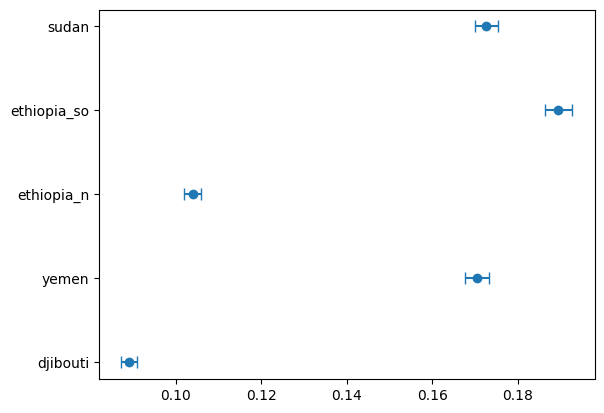

In [197]:
plt.errorbar(x=apdf['f3'],y=apdf['popa'],xerr=apdf['se'], fmt='o', capsize=4)

<ErrorbarContainer object of 3 artists>

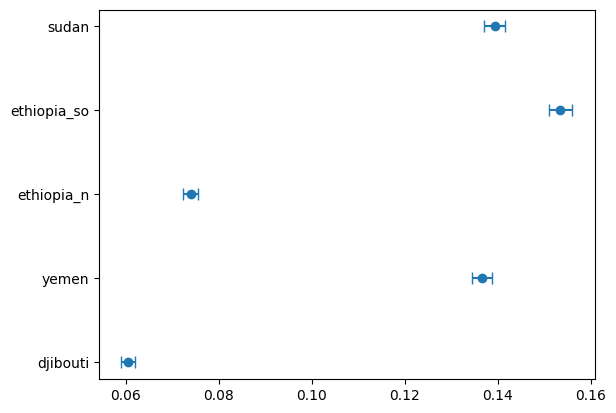

In [198]:
plt.errorbar(x=inddf['f3'],y=inddf['popa'],xerr=inddf['se'], fmt='o', capsize=4)

In [178]:
inddf

,popa,popb,popc,f3,se,z
0,djibouti,india_m,saudi_e,0.060506,0.001465,41.299246
0,yemen,india_m,saudi_e,0.136545,0.002215,61.644771
0,ethiopia_n,india_m,saudi_e,0.073915,0.001520,48.626219
0,ethiopia_so,india_m,saudi_e,0.153443,0.002557,60.006470
0,sudan,india_m,saudi_e,0.139276,0.002172,64.130516


In [179]:
apdf

,popa,popb,popc,f3,se,z
0,djibouti,afgh_pak,saudi_e,0.089147,0.001838,48.512990
0,yemen,afgh_pak,saudi_e,0.170417,0.002735,62.314942
0,ethiopia_n,afgh_pak,saudi_e,0.103977,0.001970,52.791909
0,ethiopia_so,afgh_pak,saudi_e,0.189510,0.003230,58.669132
0,sudan,afgh_pak,saudi_e,0.172628,0.002678,64.454162
